# Case Study: Macaulay & Svensson, *Cell Reports* (2016)
Olga: print this paper for people to have

This "Case Study" is somewhat like a journal club except instead of just presenting the paper, we're going to re-work through some of these analyses ourselves and see how the interpretation of the data changes by using different algorithms

We will be using In this paper, co-authors Macaulay and Svensson studied haematopoesis in Zebrafish by doing...

* Clustered cells into groups (Figure 1)
* Ordered them by psuedotime (Figure 2)
* Showed expression of known (Figure 3) and novel (Figure 4) lineage markers
* Found a novel early committed group in the kidney before circulation in the blood (Figure 5)
* Identified genes that were differentially regulated over pseudotime (Figure 6)
* Investigated usage of duplicated genes during thrombopoeisis (Figure 7)

For the purposes of this case study

## Figure 1

<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>


**A.** In this study, the authors focused on "thrombocytes," which are the equivalent of megakaryotes in fish, and are marked by expression of CD41. TThey performed single-cell RNA-seq on FACS-sorted GFP+ cells from a CD41:EGFP transgenic fish, using the C1, aligning to the genome using STAR and used Salmon to quantify gene expression. <br>
**B.** They then performed ICA and did t-SNE on the ICA components! They're colored by whether this was a high or low GFP expressing cell.<br>
**C.** They then clustered the cells into groups by cutting a hierarchical clustering tree.

![Figure 1](figures/figure1.png)

Let's dig into this a little deeper. What if they did PCA instead of ICA? Or MDS instead of t-SNE? Or no previous filtering before t-SNE? How did they define their clusters?

Make a directory for saving the figures

In [17]:
mkdir figures

mkdir: figures: File exists


Load all Python libraries and the data.

In [18]:
# Must be the first import for compatibility reasons
from __future__ import print_function

# Alphabetical order of modules is convention
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import linalg
import seaborn as sns
from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import TSNE, MDS

# Use plotting settings that I like
sns.set(style='white', context='talk')
%matplotlib inline


genes = pd.read_csv('macaulay2016/gene_expression_s.csv', index_col=0).sort_index(0).sort_index(1)
sample_data = pd.read_csv('macaulay2016/sample_info_qc.csv', index_col=0).sort_index(0).sort_index(1)

genes = genes.ix[:, sample_data[sample_data["Pass QC"]].index]
sample_data = sample_data[sample_data["Pass QC"]]
sample_data['condition_color'] = ['#31a354' if c == 'HIGH' else '#e5f5e0' for c in sample_data['condition']]


ercc_idx = filter(lambda i: 'ERCC' in i, genes.index)
egenes = genes.drop(ercc_idx)
egenes = egenes.drop('GFP')

egenes = (egenes / egenes.sum()) * 1e6

mask = (egenes > 1).sum(1) > 2
egenes = egenes.ix[mask]
original_expression_data = np.log10(egenes.T + 1).copy()

gene_annotation = pd.read_csv('macaulay2016/zv9_gene_annotation.txt', sep='\t', index_col=0)
gene_annotation = gene_annotation.ix[egenes.index]

# --- Read their supplemental data to get the assigned clusters from the paper, for comparison --- #
supplemental_data_sample_info = pd.read_csv('supplementary-data-1-sample-info/original_experiment_sample_info.csv', index_col=0)
# Convert the string of tuples into a (r,g,b) tuple for matplotlib
supplemental_data_sample_info['cluster_color'] = supplemental_data_sample_info['cluster_color'].map(eval)
supplemental_data_sample_info = supplemental_data_sample_info.reindex(index=original_expression_data.index)

Interactive function for trying dimensionality reduction and different components.

They said to pick their cutoff they used the frobenius norm reconstruction error, meaning, the difference between the ICA- or PCA-predicted matrix given the number of components, versus the original matrix, which we will plot as well. 

reconstruction norms: [ 1751.20620998  1739.78178032  1734.35601763  1730.34291511  1726.86781614
  1723.63523048  1720.70299298  1718.15430582  1715.6544435   1713.34224122]


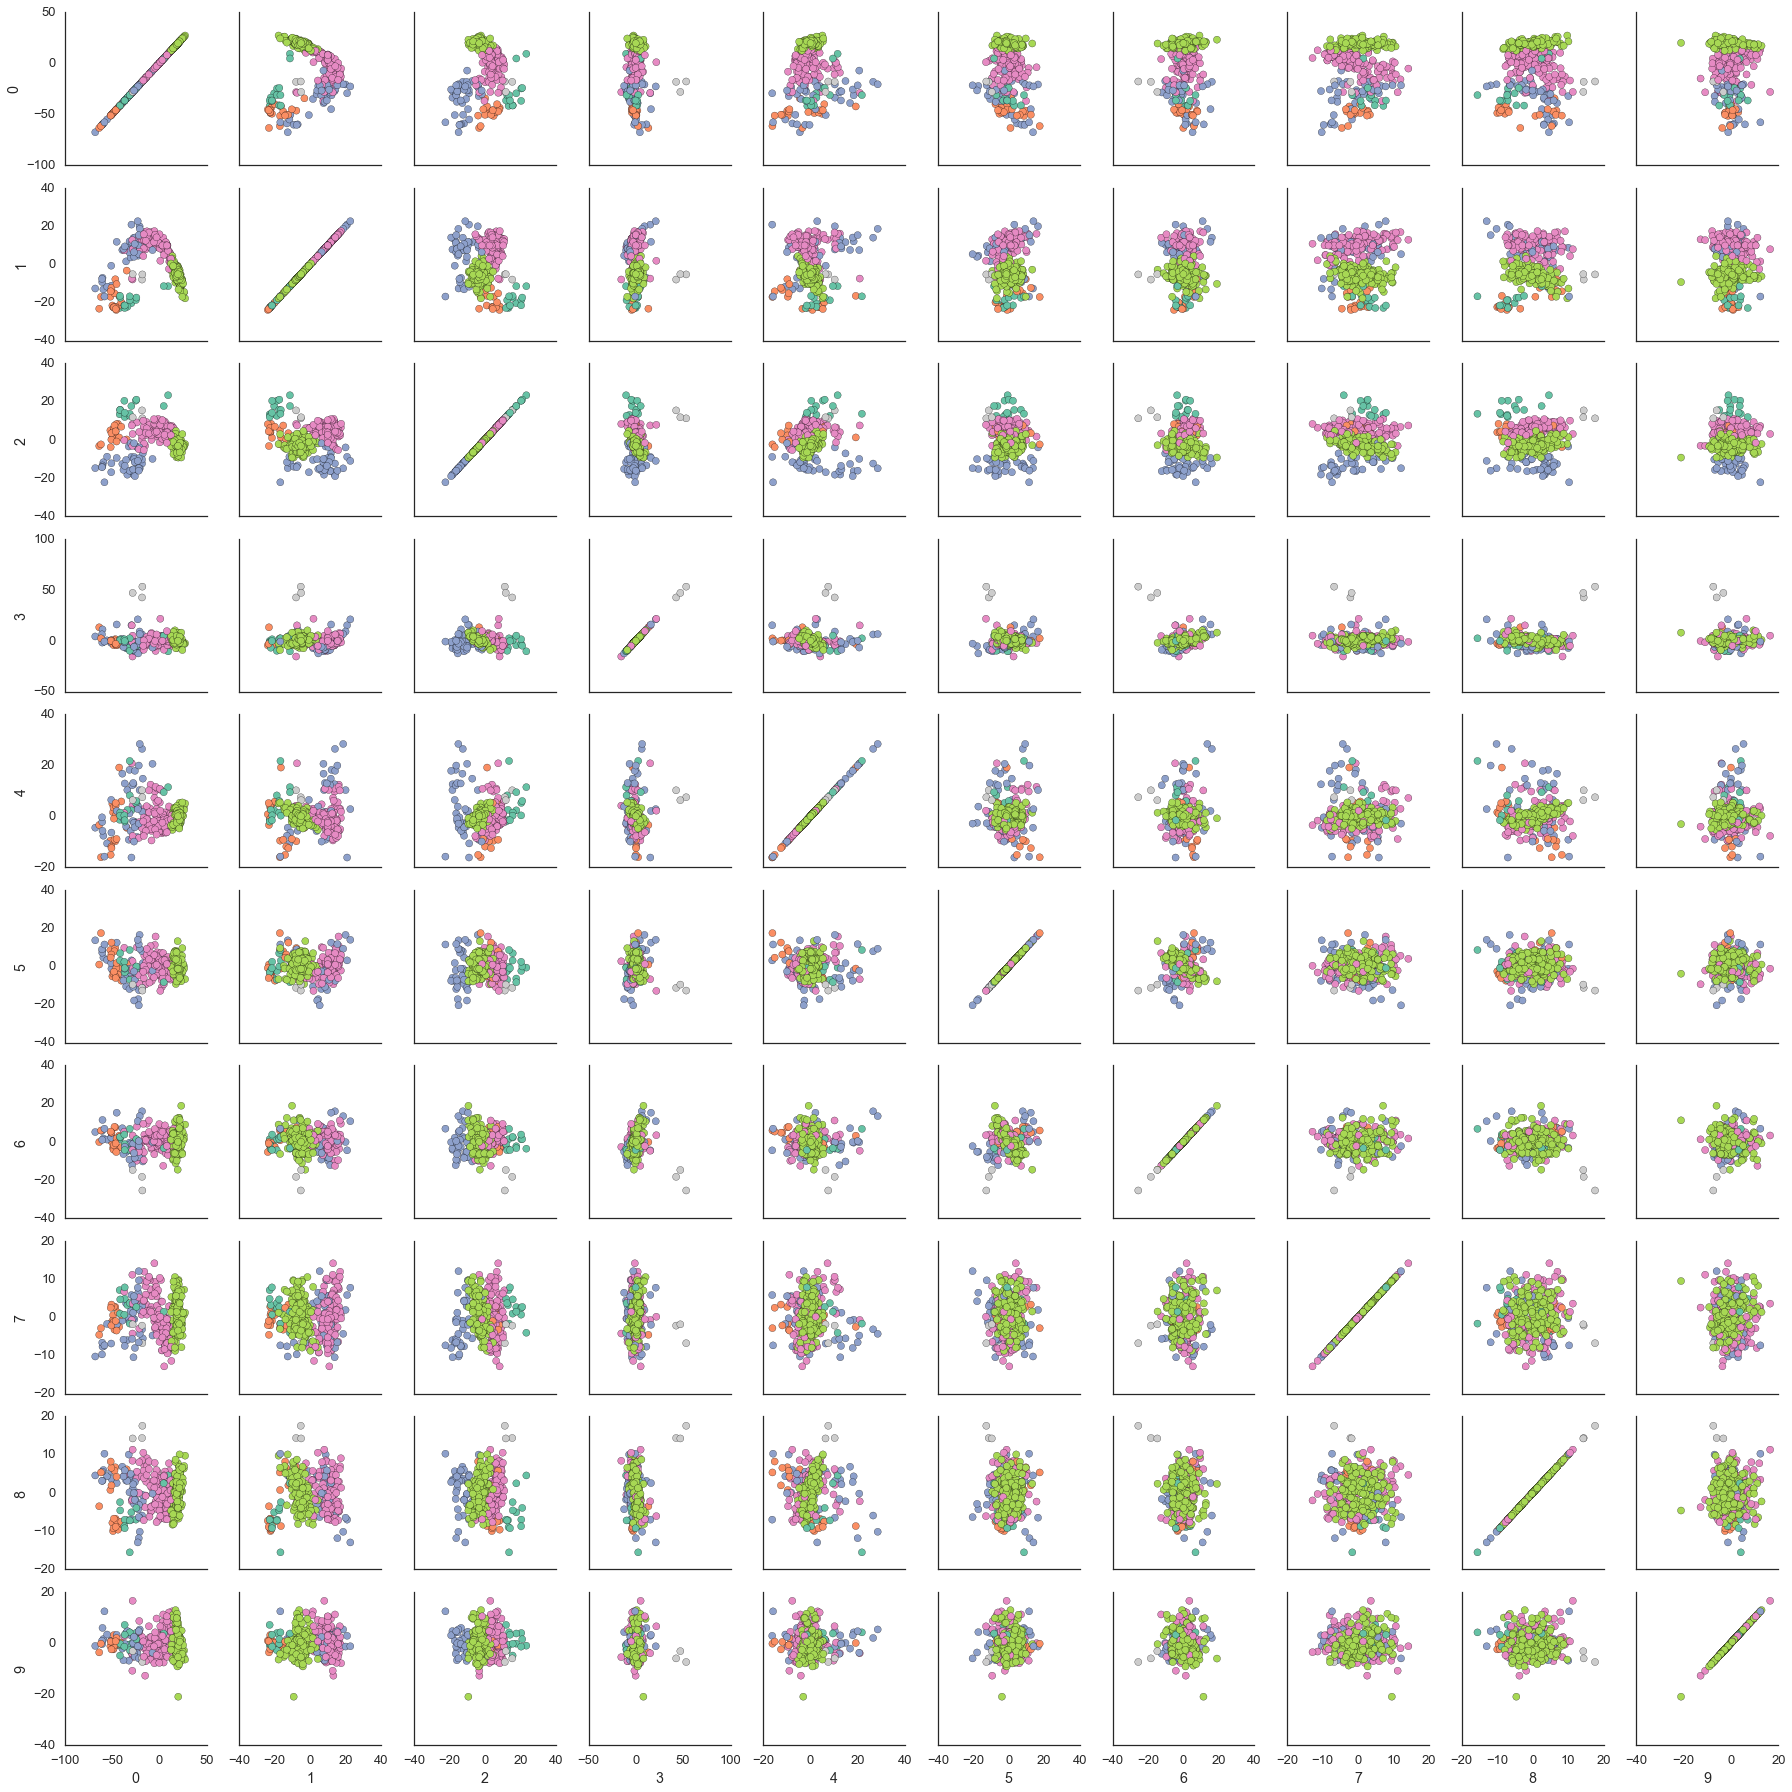

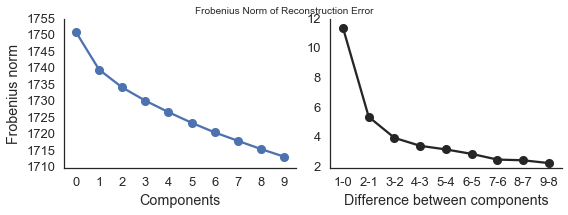

In [19]:
def explore_matrix_decomposition(algorithm, n_components, color_by):
    
    if algorithm == 'ICA':
        reducer = FastICA(n_components, random_state=3984)
    elif algorithm == 'PCA':
        reducer = PCA(n_components)

    Y = reducer.fit_transform(original_expression_data.copy())

    XX = pd.DataFrame(Y, index=egenes.columns)
    if n_components == 4 and algorithm == 'ICA':
        XX.columns = ['difference_component', 'within_small_component', 'outlier_component', 'within_large_component']

    if color_by == 'EGFP':
        color = sample_data['condition_color']
    elif color_by == 'Cluster assignment':
        color = supplemental_data_sample_info['cluster_color']
    
    g = sns.PairGrid(XX)
    g.map(plt.scatter, color=color, linewidths=0.25, edgecolors='k', s=50)

    # Reduce the number of ticks
    for ax in g.axes.flat:
        ax.locator_params(nbins=4)
    
    # --- Get how well this number of components reconstructs the original data --- #
    reconstruction_norms = []
    for i in range(1, n_components+1):
        reconstructed = pd.DataFrame(XX.values[:, :i].dot(reducer.components_[:i, :]), 
                                     index=original_expression_data.index, 
                                     columns=original_expression_data.columns)

        reconstruction_error = original_expression_data.subtract(reconstructed).abs()
        reconstruction_norms.append(np.linalg.norm(reconstruction_error))

    reconstruction_norms = np.array(reconstruction_norms)
    print('reconstruction norms:', reconstruction_norms)
    cumulative_difference = reconstruction_norms[:-1] - reconstruction_norms[1:]
    xticks = np.arange(n_components)
    
    fig, axes = plt.subplots(figsize=(8, 3), ncols=2)
    ax = axes[0]
    ax.plot(reconstruction_norms, 'o-')
    ax.set(xlabel='Components', ylabel='Frobenius norm', xticks=xticks, 
           xlim=(-0.5, n_components-0.5))
    
    ax = axes[1]
    plt.sca(ax)
    ax.plot(cumulative_difference, 'o-', color='#262626')  # #262626 = 90% black
    xticklabels = ['{}-{}'.format(i+1, i) for i in range(n_components-1)]
    ax.set(xticklabels=xticklabels, xlabel='Difference between components', xticks=xticks, 
           xlim=(-0.5, n_components-1.5))
    fig.suptitle("Frobenius Norm of Reconstruction Error")
    sns.despine()

ipywidgets.interact(explore_matrix_decomposition, 
                    algorithm=ipywidgets.Dropdown(options=['PCA', 'ICA'], value='ICA'), 
                    n_components=ipywidgets.IntSlider(value=4, min=2, max=10, step=1),
                    color_by=ipywidgets.Dropdown(options=['EGFP', 'Cluster assignment'], value='EGFP'));

Write a short function to abstract away possibly decomposing the data into parts, or maybe not.

In [5]:
ICA_PCA = ('ICA', "PCA")
def maybe_decompose(matrix_decomposer, n_components):
    if matrix_decomposer in ICA_PCA:
        if matrix_decomposer == 'ICA':
            reducer = FastICA(n_components, random_state=3984)
        elif matrix_decomposer == 'PCA':
            reducer = PCA(n_components)

        decomposed = reducer.fit_transform(original_expression_data.copy())
        decomposed = pd.DataFrame(decomposed, index=egenes.columns)
    
        if n_components == 4 and matrix_decomposer == 'ICA':
            decomposed.columns = ['difference_component', 'within_small_component', 
                                  'outlier_component', 'within_large_component']
    else:
        decomposed = original_expression_data.copy()
    return decomposed

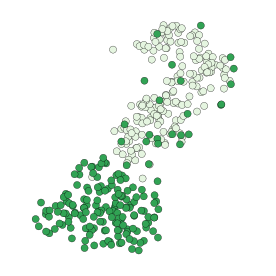

In [25]:
def explore_manifold_learning(matrix_decomposer, n_components, color_by, manifold_learner):
    decomposed = maybe_decompose(matrix_decomposer, n_components)

    if manifold_learner == 't-SNE':
        embedder = TSNE(n_components=2, perplexity=75, random_state=254)
    elif manifold_learner == 'MDS':
        embedder = MDS(n_components=2, random_state=254)

    embedded = embedder.fit_transform(decomposed)
    embedded = pd.DataFrame(embedded, index=decomposed.index)

    fig, ax = plt.subplots(figsize=(4, 4))
    
    if color_by == 'EGFP':
        color = sample_data['condition_color']
    elif color_by == 'Cluster assignment':
        color = supplemental_data_sample_info['cluster_color']

    plt.scatter(embedded[0], embedded[1], c=color, s=50)
    # Empty the tick labels
    ax.set(xticks=[], yticks=[])
    sns.despine(bottom=True, left=True)
    fig.tight_layout()

ipywidgets.interact(explore_manifold_learning, 
                    matrix_decomposer=ipywidgets.Dropdown(options=['PCA', 'ICA', "None"], value='ICA'), 
                    n_components=ipywidgets.IntSlider(value=4, min=2, max=10, step=1),
                    color_by=ipywidgets.Dropdown(options=['EGFP', 'Cluster assignment'], value='EGFP'),
                    manifold_learner=ipywidgets.Dropdown(options=['t-SNE', 'MDS'], value='t-SNE'));

### How did they assign cells to clusters?

The authors used hierarchical clustering with the ward algorithm, and cut the tree at a couple different thresholds to get broad clusters, and did a smaller cut to get finer clusters

In [21]:
"""
Cluster assignment and coloring functions from supplemental notebooks
"""

from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter 

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = list(sorted([den[label][i] for i in l]))
        cluster_classes[c] = i_l

    return cluster_classes

def get_cluster_limits(den):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_limits = Clusters()
    for c in cluster_idxs:
        cluster_limits[c] = (min(cluster_idxs[c]), max(cluster_idxs[c]))
    
    return cluster_limits

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


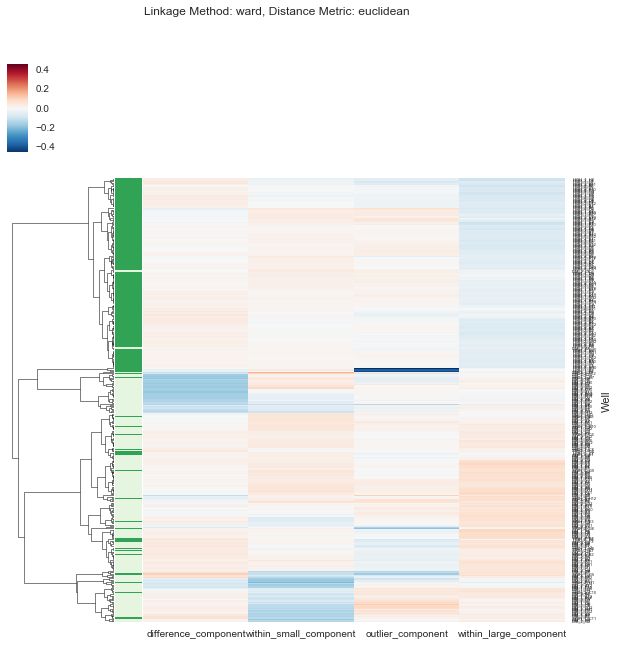

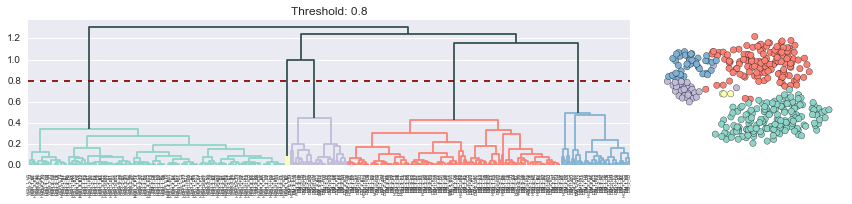

In [24]:
from scipy.cluster import hierarchy
import matplotlib as mpl

# Make the clustering dendrogram colors not suck
hierarchy.set_link_color_palette(list(map(mpl.colors.rgb2hex, sns.color_palette('Set3', n_colors=12))))


def explore_clustering(method, metric, dendrogram_thresh, matrix_decomposer, n_components, col_cluster=False):
    decomposed = maybe_decompose(matrix_decomposer, n_components)
    
    # Don't cluster columns when the data isn't decomposed because the raw number of genes is too big
    if col_cluster and matrix_decomposer not in ICA_PCA:
        print("Cowardly refusing to cluster the columns when the matrix isn't decomposed because it'll take forever")
        col_cluster = False
        
    clustergrid = sns.clustermap(decomposed, method=method, lw=0, col_cluster=col_cluster, metric=metric,
                                 row_colors=sample_data['condition_color']);
    plt.setp(clustergrid.ax_heatmap.get_yticklabels(), rotation=0, fontsize=4)
    clustergrid.fig.suptitle('Linkage Method: {}, Distance Metric: {}'.format(method, metric))
    
    # --- Set up dendrogram + t-SNE figure --- #
    width, height = 12, 3
    fig, axes = plt.subplots(figsize=(width, height), ncols=2, gridspec_kw=dict(width_ratios=(.75, .25)))

    # --- Plot dendrogram --- #
#     sns.set(style='darkgrid')
    ax = axes[0]
    # sca = "Set current axes"
    plt.sca(ax)
    cden = hierarchy.dendrogram(clustergrid.dendrogram_row.linkage, color_threshold=dendrogram_thresh, 
                                labels=decomposed.index, above_threshold_color='DarkSlateGray');
    xmin, xmax = ax.get_xlim()
    if dendrogram_thresh <= xmin:
        print("The dendrogram threshold is below the axes .. there will be one cluster for all cells")
    if dendrogram_thresh >= xmax:
        print("The dendrogram threshold is above the axes .. there will be one cluster for all cells")
    
    ax.hlines(dendrogram_thresh, xmin, xmax, color='DarkRed', linestyle='--');
    ax.set_axis_bgcolor("#EAEAF2")
    ax.grid(axis='y', color='white', zorder=1000)
    ax.set(title='Threshold: {:g}'.format(dendrogram_thresh))
    plt.setp(ax.get_xticklabels(), rotation=90, fontsize=4)
    sns.despine(ax=ax, bottom=True, left=True)
    
    # --- Get cluster-defined colors for each cell, for this threshold --- #
    clusters = get_cluster_classes(cden)
    cell_color = []
    for cell in decomposed.index:
        for color in clusters:
            if cell in clusters[color]:
                cell_color.append(color)
                break
    
    # --- perform t-SNE --- #
    embedder = TSNE(n_components=2, perplexity=75, random_state=254)
    embedded = embedder.fit_transform(decomposed)
    embedded = pd.DataFrame(embedded, index=decomposed.index)

    # --- Plot the t-SNE result with the cell colors --- #
]
    
ipywidgets.interact(explore_clustering,
                    method=ipywidgets.Dropdown(options=['ward', 'single', 'complete', 'average'], 
                                               value='ward', description='Linkage Method'),
                    metric=ipywidgets.Dropdown(options=['euclidean', 'cityblock', 'correlation'], 
                                               value='euclidean', description='Distance Metric'),
                    col_cluster=ipywidgets.Checkbox(value=False, description="Cluster the columns?"),
                    dendrogram_thresh=ipywidgets.FloatText(value=0.8, description='Tree cut clustering threshold'),
                    matrix_decomposer=ipywidgets.Dropdown(options=['PCA', 'ICA'], 
                                                          value='ICA', description='Matrix decomposition algorithm'), 
                    n_components=ipywidgets.IntSlider(value=4, min=2, max=10, step=1, 
                                                      description='Number of components'),);

#### Exploring Clustering - please note below

* With "ward" clustering, can only use "euclidean" distance. Try some other distance and you will get an error!
* The "Tree cut clustering threshold" thing is tricky - every time any value changes, the entire thing gets recalculated. Best thing to do is to write the threshold you want outside of the box, and then copy-paste it in.
* This has a built-in fail-safe to not cluster the columns (components or genes) when you don't decompose the data first, because it'll take too long because there are 20,672 genes. In general, <10k, ideally ~5k is best for clustering because of compute power and how much you'll get out of seeing the clusters
* With ICA and 4 components try these two thresholds: (These are what they used in the paper)
    * 0.8
    * 0.442

## Figure 2

![](figures/figure2.png)